In [ ]:
import numpy as np
import pandas as pd
from math import log, sqrt, pi, exp, floor, ceil
from scipy.stats import norm
from datetime import datetime, date
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('KO.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,28.580000,28.610001,28.450001,28.520000,19.646149,13870400
2010-01-05,28.424999,28.495001,28.070000,28.174999,19.408495,23172400
2010-01-06,28.174999,28.219999,27.990000,28.165001,19.401609,19264600
2010-01-07,28.165001,28.184999,27.875000,28.094999,19.353386,13234600
2010-01-08,27.730000,27.820000,27.375000,27.575001,18.995186,28712400


In [ ]:
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))

def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)

def calculate_option_price(mode, spot, strike, r, t, sigma):
    if mode == 'call':
        return bs_call(spot, strike, t, r, sigma)
    return bs_put(spot, strike, t, r, sigma)

In [ ]:
def run_strategy(data, short_period, long_period, signal_period, expiry_days):
    r = 0.02
    df = data.copy()
    
    df['EMA_short'] = df['Close'].ewm(span=short_period).mean() #can change adjust to FALSE maybe
    df['EMA_long'] = df['Close'].ewm(span=long_period).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['signal'] = df['MACD'].ewm(span=signal_period).mean()
    
    df['close_day_before'] = df['Close'].shift(-1)
    df['returns'] = (df['Close'] - df['close_day_before'])/df['close_day_before']
    sigma = np.sqrt(252) * df['returns'].std()

    
    df['position'] = np.nan
    df['account'] = 0
    df['P&L'] = 0
    
    position = 0
    can_trade = True
    own_stock = False
    days_to_expiry = expiry_days
    account = 0
    strike = -1 # this will keep track of the current strike of our position
    puts_sold = 0
    calls_sold = 0
    puts_lost = 0
    calls_lost = 0
    
    for date_index, date in enumerate(df.index):
        if not can_trade:
            if days_to_expiry <= 0:
                if position == 1:
                    # we sold a put, so check to see if spot is below strike
                    if df.loc[date, 'Close'] < strike:
                        # we must buy 100 shares at the strike price
                        puts_lost += 1
                        account = account - (100 * strike)
                        own_stock = True
                if position == -1:
                    # we sold a call, so check to see if spot is above strike
                    if df.loc[date, 'Close'] > strike:
                        calls_lost += 1
                        account += 100 * strike
                        own_stock = False
                
                df.loc[date, 'account'] = account
                if own_stock:
                    df.loc[date, 'P&L'] = account + 100 * df.loc[date, 'Close']
                else:
                    df.loc[date, 'P&L'] = account
                df.loc[date, 'position'] = position
                
                position = 0
                days_to_expiry = expiry_days
                can_trade = True
                continue
            else:
                df.loc[date, 'account'] = account
                if own_stock:
                    df.loc[date, 'P&L'] = account + 100 * df.loc[date, 'Close']
                else:
                    df.loc[date, 'P&L'] = account
                df.loc[date, 'position'] = position
                days_to_expiry -= 1
                continue
            
        if df.loc[date, 'signal'] < df.loc[date, 'MACD'] and df.iloc[date_index-1]['signal'] > df.iloc[date_index-1]['MACD']:
            if can_trade and not own_stock:
                # sell cash-secured put
                puts_sold += 1
                spot = df.loc[date, 'Close']
                strike = floor(spot-1)
                try:
                    days_to_expiry = (df.index[date_index + expiry_days] - df.index[date_index]).days
                    expiry = days_to_expiry / 365
                except:
                    days_to_expiry = (df.index[len(df) - 1] - df.index[date_index]).days
                    expiry = days_to_expiry / 365
                put_price = calculate_option_price('put', spot, strike, expiry, r, sigma)
                
                account += 100 * put_price
                position = 1
                
                df.loc[date, 'position'] = position # 1 means we sell put
                
                can_trade = False
        elif df.loc[date, 'signal'] > df.loc[date, 'MACD'] and df.iloc[date_index-1]['signal'] < df.iloc[date_index-1]['MACD']:
            if can_trade and own_stock:
                # sell covered call
                calls_sold += 1
                spot = df.loc[date, 'Close']
                strike = ceil(spot+1)
                try:
                    days_to_expiry = (df.index[date_index + expiry_days] - df.index[date_index]).days
                    expiry =  days_to_expiry / 365
                except:
                    days_to_expiry = (df.index[len(df) - 1] - df.index[date_index]).days
                    expiry = days_to_expiry / 365
                call_price = calculate_option_price('call', spot, strike, expiry, r, sigma)
                
                account += 100 * call_price
                position = -1
                
                df.loc[date, 'position'] = position # -1 means we sell call
                
                can_trade = False
        df.loc[date, 'account'] = account
        if own_stock:
            df.loc[date, 'P&L'] = account + 100 * df.loc[date, 'Close']
        else:
            df.loc[date, 'P&L'] = account
        df.loc[date, 'position'] = position
        
    if own_stock:
        account += 100 * df.iloc[len(df)-1]['Close']
        df.loc[date, 'account'] = account
    print('Sold {} puts, {} of them were executed. Sold {} calls, {} of them were executed'.format(puts_sold, puts_lost, calls_sold, calls_lost))
    return df

In [ ]:
def get_sharpe(r, rfr=0.02):
    if r.std():
        return (r.mean() - rfr) / r.std() * np.sqrt(252)
    return 0

In [ ]:
def calculate_sharpe_n_periods(r, n=252, rfr=0.02):
    if r.std():
        rfr_n = ((rfr+1)**(1/n) - 1)
        print('RFR in n=%d periods per year:' % n, rfr_n)
        return (r.mean() - rfr_n) / r.std() * np.sqrt(n)
    return 0

# plt.plot(standard_BB_train_df['P&L'])
# plt.title("Daily PNL (% change relative to portfolio value)")
# plt.show()

# print()
# print('Sharpe: ', calculate_sharpe_n_periods(standard_BB_train_df['P&L'], 252, 0.02))

In [ ]:
# Sharpe Calculated with P&L (very positive)
new_data = run_strategy(data, 24, 52, 14, 20)
print('Sharpe: {}'.format(get_sharpe(new_data['P&L'])))

Sold 26 puts, 9 of them were executed. Sold 21 calls, 9 of them were executed
Sharpe: 17.113287250151362


In [ ]:
# Sharpe Calculated with Account (very negative)
print('Sharpe: {}'.format(get_sharpe(new_data['account'])))

Sharpe: -9.237456330481127


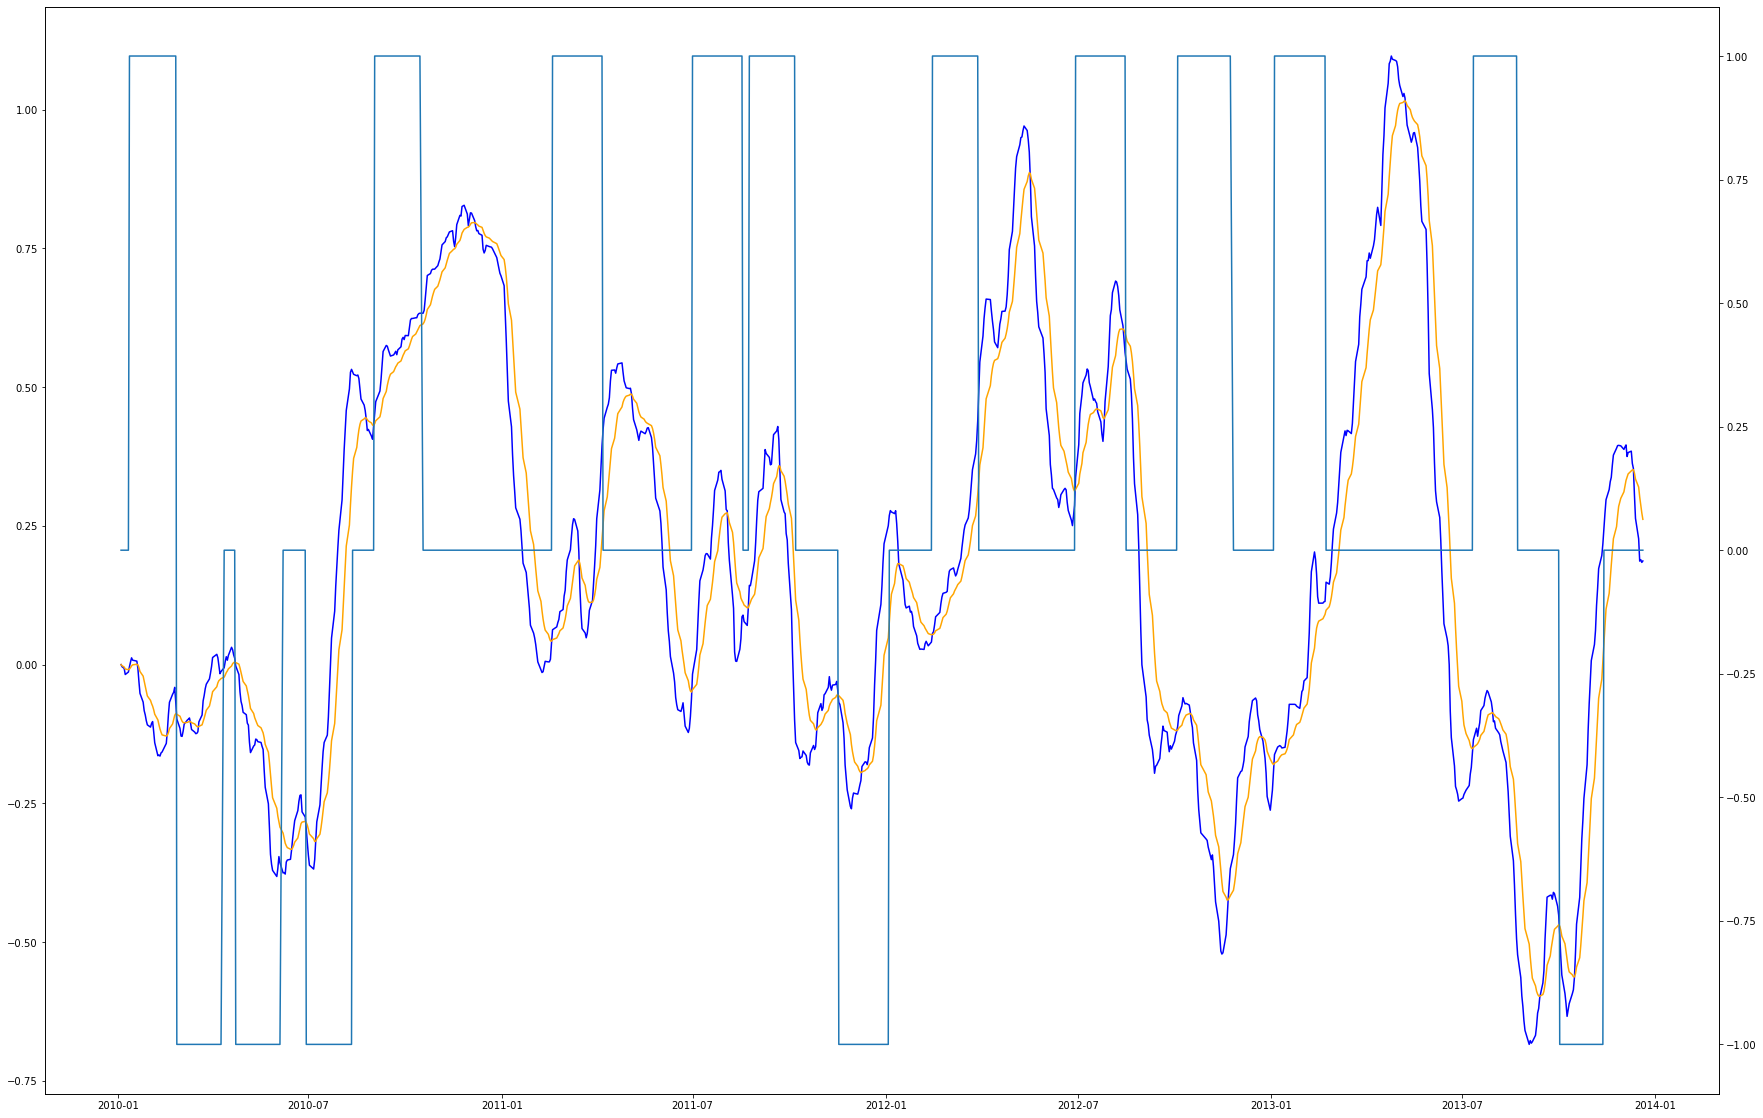

In [ ]:
df = new_data[0:1000]

fig, ax = plt.subplots(figsize=(30, 20))
ax.plot(df.index, df['MACD'], color = 'blue')
ax.plot(df.index, df['signal'], color = 'orange')
# ax.plot(df.index, df['Close'], color = 'orange')

ax2 = ax.twinx()
ax2.plot(df.index, df['position'])

plt.show()

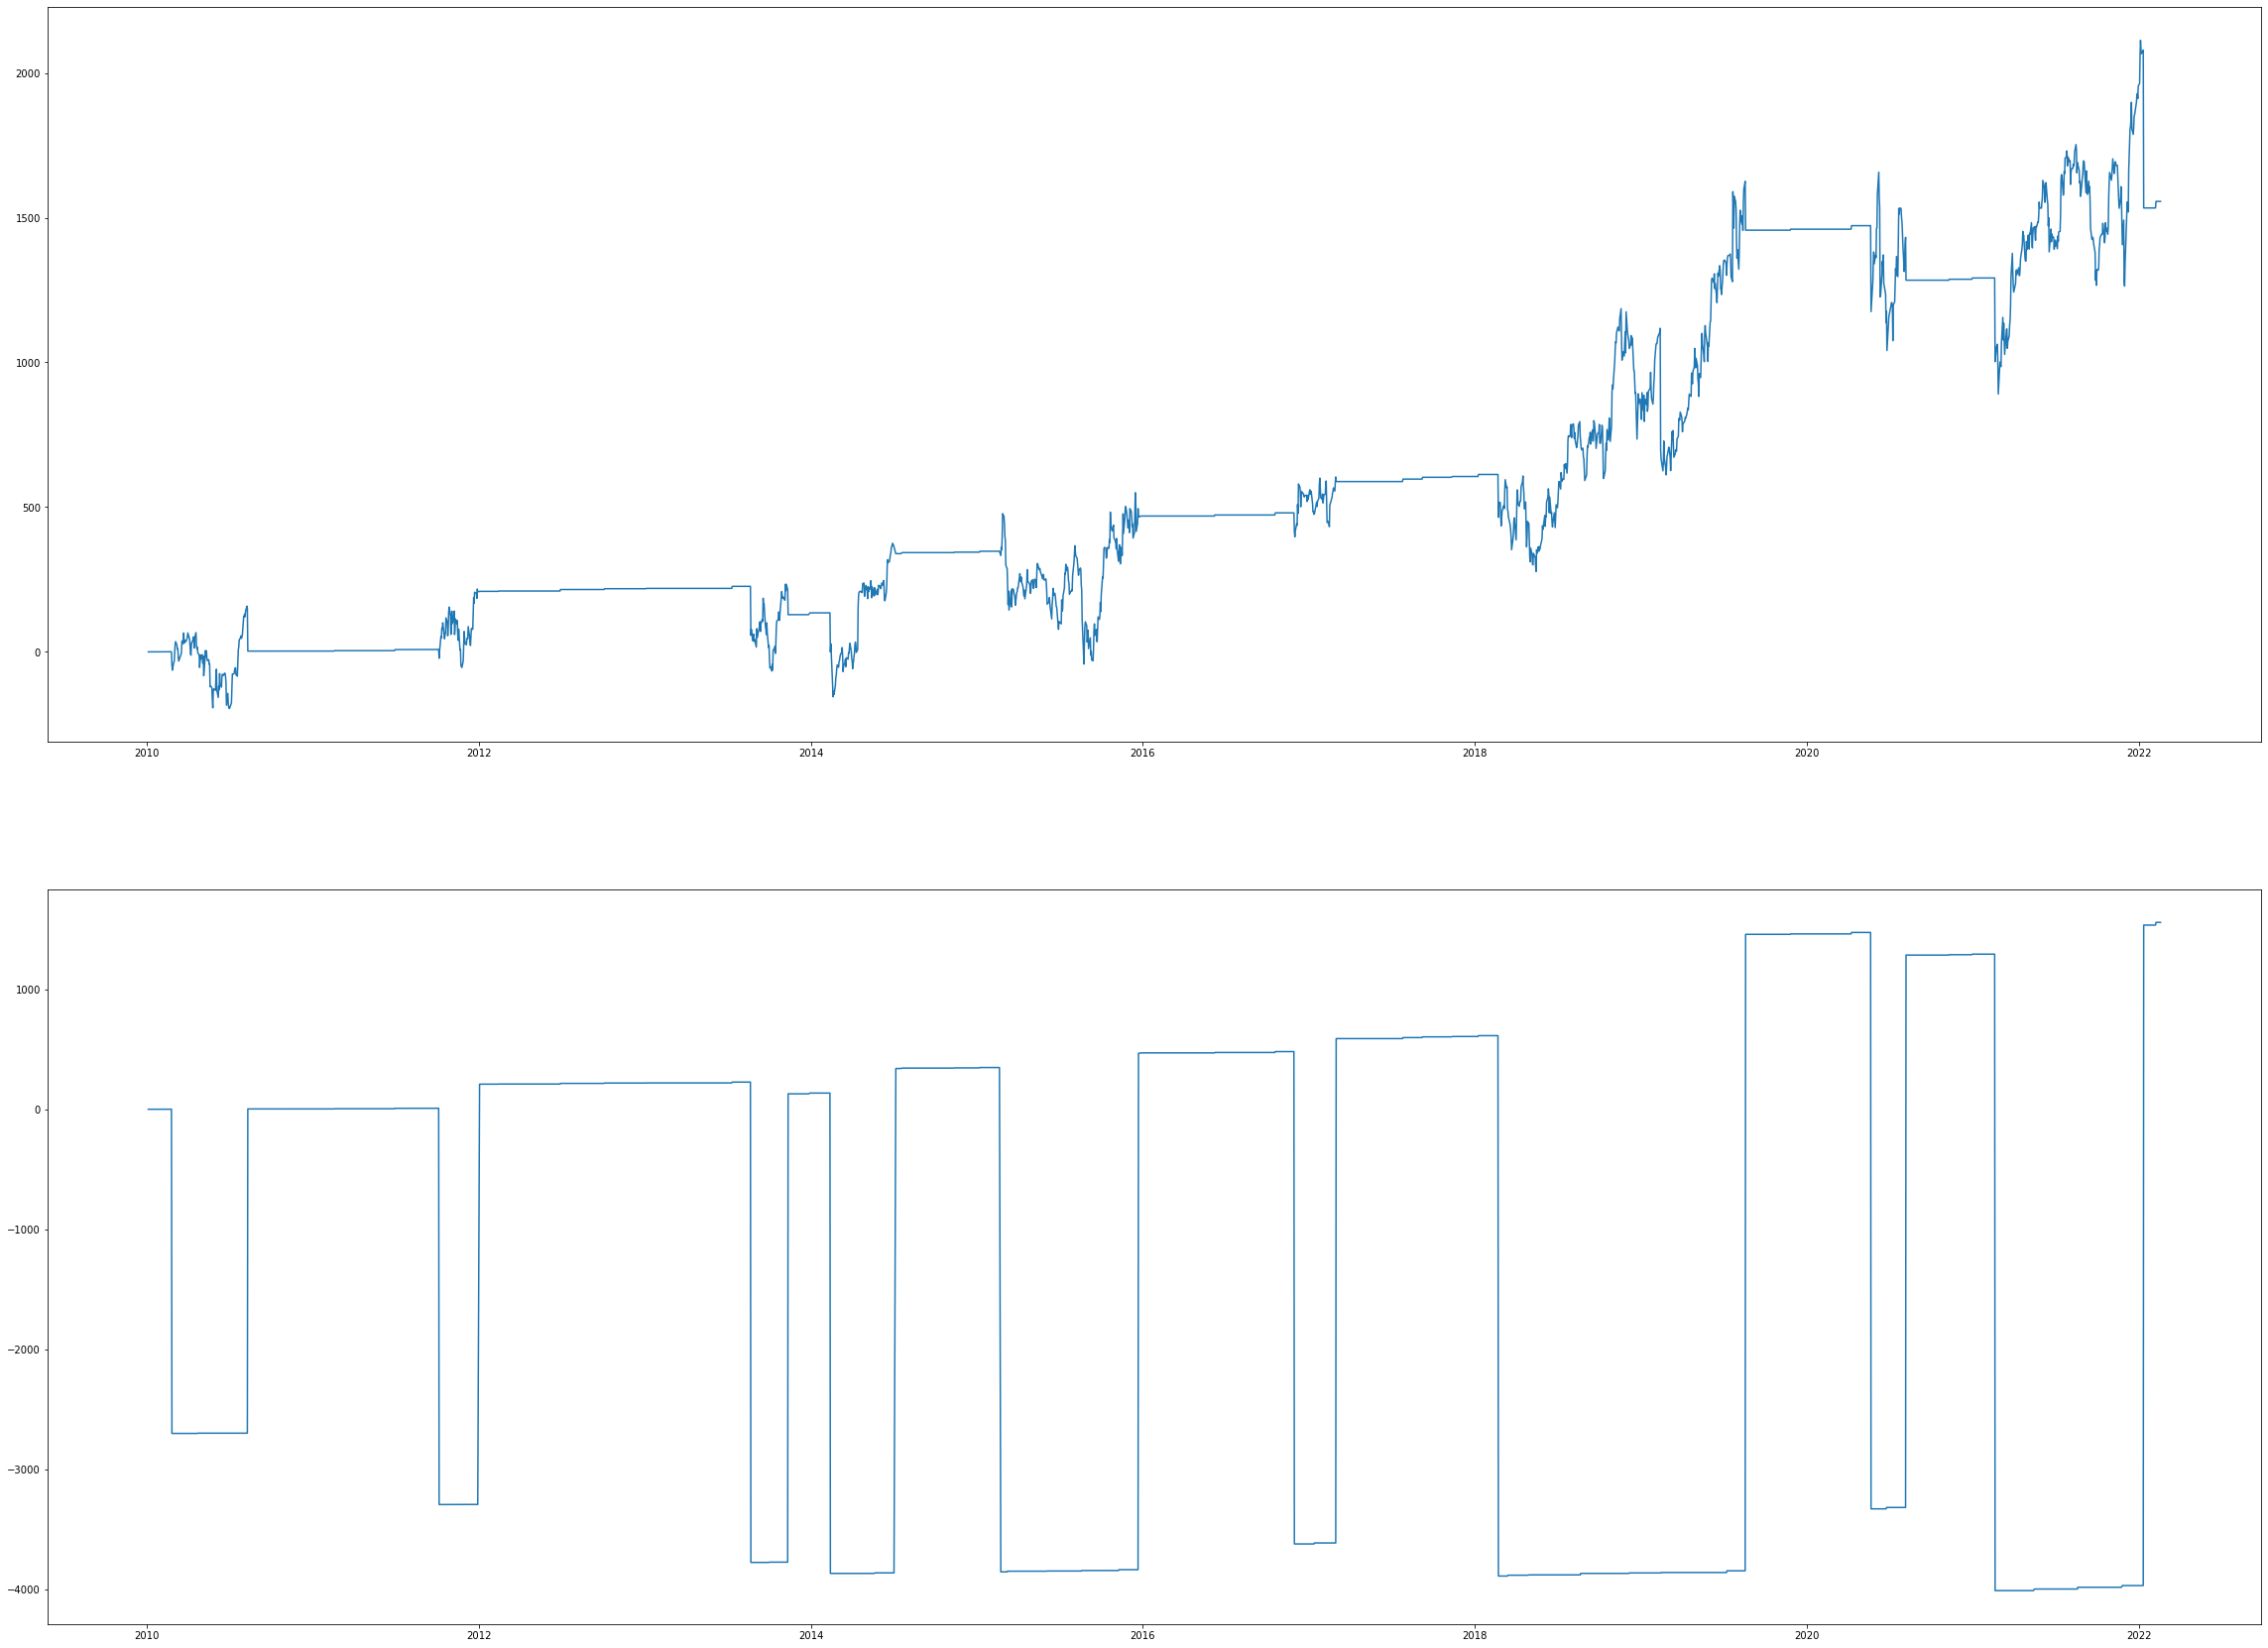

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(40, 30))

axes[0].plot(new_data.index, new_data['P&L'])
axes[1].plot(new_data.index, new_data['account'])
plt.show()

In [ ]:
train_sharpes = []
for short in [12, 18, 24]:
    for long in [26, 38, 52]:
        for signal in [9, 14]:
            for expiry in [20]:
                df = run_strategy(data, short, long, signal, expiry)
                train_sharpes.append({
                    'short': short,
                    'long': long,
                    'signal': signal,
                    'expiry': expiry,
                    'sharpe_p&l': get_sharpe(df['P&L']),
                    'sharpe_account': get_sharpe(df['account'])
                })

Sold 46 puts, 6 of them were executed. Sold 20 calls, 6 of them were executed
Sold 36 puts, 5 of them were executed. Sold 27 calls, 5 of them were executed
Sold 36 puts, 5 of them were executed. Sold 27 calls, 5 of them were executed
Sold 41 puts, 6 of them were executed. Sold 17 calls, 6 of them were executed
Sold 37 puts, 6 of them were executed. Sold 23 calls, 6 of them were executed
Sold 35 puts, 6 of them were executed. Sold 20 calls, 6 of them were executed
Sold 36 puts, 5 of them were executed. Sold 27 calls, 5 of them were executed
Sold 39 puts, 7 of them were executed. Sold 19 calls, 7 of them were executed
Sold 41 puts, 6 of them were executed. Sold 17 calls, 6 of them were executed
Sold 34 puts, 6 of them were executed. Sold 20 calls, 6 of them were executed
Sold 40 puts, 6 of them were executed. Sold 17 calls, 6 of them were executed
Sold 24 puts, 8 of them were executed. Sold 25 calls, 8 of them were executed
Sold 38 puts, 6 of them were executed. Sold 21 calls, 6 of them 

In [ ]:
train_sharpes

[{'short': 12,
  'long': 26,
  'signal': 9,
  'expiry': 20,
  'sharpe_p&l': 19.913497714897527,
  'sharpe_account': -5.372885819756573},
 {'short': 12,
  'long': 26,
  'signal': 14,
  'expiry': 20,
  'sharpe_p&l': 22.712113799236118,
  'sharpe_account': -8.930196077803476},
 {'short': 12,
  'long': 38,
  'signal': 9,
  'expiry': 20,
  'sharpe_p&l': 22.688265293109552,
  'sharpe_account': -8.940672094682467},
 {'short': 12,
  'long': 38,
  'signal': 14,
  'expiry': 20,
  'sharpe_p&l': 18.18242125597429,
  'sharpe_account': -5.4480507043794},
 {'short': 12,
  'long': 52,
  'signal': 9,
  'expiry': 20,
  'sharpe_p&l': 22.7825750970698,
  'sharpe_account': -7.087071658065431},
 {'short': 12,
  'long': 52,
  'signal': 14,
  'expiry': 20,
  'sharpe_p&l': 14.392925384324693,
  'sharpe_account': -7.55215011217796},
 {'short': 18,
  'long': 26,
  'signal': 9,
  'expiry': 20,
  'sharpe_p&l': 22.669297943924764,
  'sharpe_account': -8.92808823411053},
 {'short': 18,
  'long': 26,
  'signal': 14,
